# Zipline Benchmarks

In [1]:
import pandas as pd
print(pd.__version__)
start, end = pd.Timestamp('2013-01-03', tz='UTC'), pd.Timestamp('2018-01-03', tz='UTC')

from zipline.pipeline import Pipeline
from zipline.utils.calendars import get_calendar
from zipline.data import bundles
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine

0.22.0


In [2]:
bundle_data = bundles.load('quandl')
zp_loader = USEquityPricingLoader(
            bundle_data.equity_daily_bar_reader, 
            bundle_data.adjustment_reader)

trading_calendar = get_calendar('NYSE') 

zpl_engine = SimplePipelineEngine(
    get_loader=lambda x: zp_loader,
    calendar=trading_calendar.all_sessions,
    asset_finder=bundle_data.asset_finder)

## Factors
--------------------

In [3]:
from zipline.pipeline.factors import SimpleMovingAverage, ExponentialWeightedMovingAverage
ma = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=100)
pipeline = Pipeline()
pipeline.add( ma, 'ma') 
%time dfzp=zpl_engine.run_pipeline(pipeline, start, end)
dfzp.head(5).append(dfzp.tail(5))

Wall time: 3.5 s


ma
2013-01-03 00:00:00+00:00 Equity(0 [A])        38.110535
                          Equity(2 [AAL])      11.776900
                          Equity(3 [AAMC])     67.738462
                          Equity(4 [AAN])      28.779516
                          Equity(6 [AAON])     19.606132
2018-01-03 00:00:00+00:00 Equity(3190 [ZIXI])   4.824444
                          Equity(3194 [ZNGA])   3.831677
                          Equity(3195 [ZOES])  13.582525
                          Equity(3197 [ZTS])   66.604667
                          Equity(3198 [ZUMZ])  17.432071

In [4]:
%timeit zpl_engine.run_pipeline(pipeline, start, end)
%timeit -n 3 -r 10 zpl_engine.run_pipeline(pipeline, start, end)

3.21 s ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.98 s ± 14.4 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)


In [4]:
pipeline = Pipeline()
ema = ExponentialWeightedMovingAverage.from_span(inputs=[USEquityPricing.close], span=50, window_length=229)
pipeline.add( ema, 'ema50')
%time dfzp=zpl_engine.run_pipeline(pipeline, start, end)
dfzp.head(5).append(dfzp.tail(5))

Wall time: 8.7 s


ema50
2013-01-03 00:00:00+00:00 Equity(0 [A])        38.896122
                          Equity(2 [AAL])      12.635515
                          Equity(3 [AAMC])           NaN
                          Equity(4 [AAN])      28.474856
                          Equity(6 [AAON])     20.191980
2018-01-03 00:00:00+00:00 Equity(3190 [ZIXI])        NaN
                          Equity(3194 [ZNGA])        NaN
                          Equity(3195 [ZOES])        NaN
                          Equity(3197 [ZTS])         NaN
                          Equity(3198 [ZUMZ])        NaN

In [5]:
%timeit zpl_engine.run_pipeline(pipeline, start, end)
%timeit -n 3 -r 10 zpl_engine.run_pipeline(pipeline, start, end)

8.35 s ± 69.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.38 s ± 56.8 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)


In [4]:
from zipline.pipeline.factors import RSI, FastStochasticOscillator, MovingAverageConvergenceDivergenceSignal
pipeline = Pipeline()
f = MovingAverageConvergenceDivergenceSignal() + RSI() + FastStochasticOscillator()
pipeline.add( f.rank().zscore(), 'f')
%time dfzp=zpl_engine.run_pipeline(pipeline, start, end)
dfzp.head(5).append(dfzp.tail(5))

Wall time: 16.3 s


f
2013-01-03 00:00:00+00:00 Equity(0 [A])        0.188150
                          Equity(2 [AAL])      0.993146
                          Equity(3 [AAMC])          NaN
                          Equity(4 [AAN])      0.151234
                          Equity(6 [AAON])    -0.490619
2018-01-03 00:00:00+00:00 Equity(3190 [ZIXI])  0.102593
                          Equity(3194 [ZNGA]) -1.137012
                          Equity(3195 [ZOES]) -0.716735
                          Equity(3197 [ZTS])  -1.025221
                          Equity(3198 [ZUMZ]) -1.103050

In [11]:
%timeit zpl_engine.run_pipeline(pipeline, start, end)
%timeit -n 3 -r 10 zpl_engine.run_pipeline(pipeline, start, end)

14.4 s ± 526 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
14.3 s ± 277 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)


## Backtesting
--------------------

In [1]:
%load_ext zipline

C:\Miniconda3\envs\zipline\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [6]:
%%time
%%zipline --start 2013-1-3 --end 2018-1-3 --capital-base 10000

from six import viewkeys
from zipline.api import (
    attach_pipeline,
    date_rules,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import RSI, AverageDollarVolume

def make_pipeline():
    rsi = RSI()
    universe = AverageDollarVolume(window_length=120).top(500)
    return Pipeline(
        columns={
            'longs': rsi.top(3),
            'shorts': rsi.bottom(3),
        },
        screen=universe
    )


def rebalance(context, data):

    # Pipeline data will be a dataframe with boolean columns named 'longs' and
    # 'shorts'.
    pipeline_data = context.pipeline_data
    all_assets = pipeline_data.index

    longs = all_assets[pipeline_data.longs]
    shorts = all_assets[pipeline_data.shorts]

    record(universe_size=len(all_assets))

    # Build a 2x-leveraged, equal-weight, long-short portfolio.
    one_third = 1.0 / 3.0
    for asset in longs:
        order_target_percent(asset, one_third)

    for asset in shorts:
        order_target_percent(asset, -one_third)

    # Remove any assets that should no longer be in our portfolio.
    portfolio_assets = longs | shorts
    positions = context.portfolio.positions
    for asset in viewkeys(positions) - set(portfolio_assets):
        # This will fail if the asset was removed from our portfolio because it
        # was delisted.
        if data.can_trade(asset):
            order_target_percent(asset, 0)

            
def initialize(context):
    attach_pipeline(make_pipeline(), 'my_pipeline')

    # Rebalance each day.  In daily mode, this is equivalent to putting
    # `rebalance` in our handle_data, but in minute mode, it's equivalent to
    # running at the start of the day each day.
    schedule_function(rebalance, date_rules.every_day())

    # Explicitly set the commission/slippage to the "old" value until we can
    # rebuild example data.
    # github.com/quantopian/zipline/blob/master/tests/resources/
    # rebuild_example_data#L105
    context.set_commission(commission.PerShare(cost=.005, min_trade_cost=1.0))
#     context.set_slippage(slippage.VolumeShareSlippage(volume_limit=100, price_impact=0))
    context.set_slippage(None)
    context.blotter.max_shares=1e16


def before_trading_start(context, data):
    context.pipeline_data = pipeline_output('my_pipeline')



C:\Miniconda3\envs\zipline\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
C:\Miniconda3\envs\zipline\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Wall time: 20.4 s


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return,universe_size
2013-01-03 21:00:00+00:00,NaN,0.000000,NaN,-0.002259,NaN,NaN,0.000000,10000.000000,0.000,0.000,...,0.000,0,NaN,10000.000000,0.000,0.000,1,[],0.0,500
2013-01-04 21:00:00+00:00,0.000000,0.000000,0.000000,0.002122,0.074658,0.000000,0.000000,10000.000000,0.000,0.000,...,0.000,0,NaN,10000.000000,0.000,0.000,2,[],0.0,500
2013-01-07 21:00:00+00:00,0.000000,0.000000,0.000000,-0.000616,0.063239,0.000000,0.000000,10000.000000,0.000,0.000,...,0.000,0,NaN,10000.000000,0.000,0.000,3,[],0.0,500
2013-01-08 21:00:00+00:00,0.000000,0.000000,0.000000,-0.003492,0.055836,0.000000,0.000000,10000.000000,0.000,0.000,...,0.000,0,NaN,10000.000000,0.000,0.000,4,[],0.0,500
2013-01-09 21:00:00+00:00,0.000000,0.000000,0.000000,-0.000959,0.054081,0.000000,0.000000,10000.000000,0.000,0.000,...,0.000,0,NaN,10000.000000,0.000,0.000,5,[],0.0,500
2013-01-10 21:00:00+00:00,0.000000,0.000000,0.000000,0.006983,0.071558,0.000000,0.000000,10000.000000,0.000,0.000,...,0.000,0,NaN,10000.000000,0.000,0.000,6,[],0.0,500
2013-01-11 21:00:00+00:00,0.000000,0.000000,0.000000,0.006915,0.065743,0.000000,0.000000,10000.000000,0.000,0.000,...,0.000,0,NaN,10000.000000,0.000,0.000,7,[],0.0,500
2013-01-14 21:00:00+00:00,0.000000,0.000000,0.000000,0.006230,0.061586,0.000000,0.000000,10000.000000,0.000,0.000,...,0.000,0,NaN,10000.000000,0.000,0.000,8,[],0.0,500
2013-01-15 21:00:00+00:00,0.000000,0.000000,0.000000,0.006915,0.057611,0.000000,0.000000,10000.000000,0.000,0.000,...,0.000,0,NaN,10000.000000,0.000,0.000,9,[],0.0,500
2013-01-16 21:00:00+00:00,0.001328,-0.000265,-0.007016,0.006778,0.054507,0.002037,3218.274540,13218.274540,-3220.920,-3220.920,...,-3220.920,1,-5.019960,10000.000000,0.000,0.000,10,[{'order_id': '862be303b0284f30858e717d5ed8901...,0.0,500


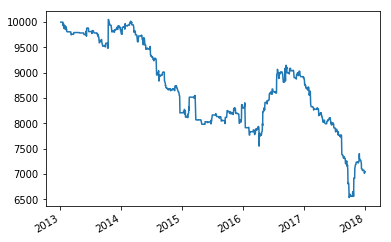

In [7]:
%matplotlib inline
_.portfolio_value.plot()